Goals:

Biopython: For calculating GC content, k-mer frequencies, ORFs, and more.


RepeatMasker: To find tandem or interspersed repeats.


HMMER/MEME Suite: For motif and pattern searches.


FASTA Tools: Command-line tools for sequence manipulation and statistics.


Features to target

GC/AT content


K-mer frequencies


Sequence length


Nucleotide skew


ORFs (if it's a coding sequence)


Palindromic sequences


Shannon entropy
Repeats and motifs (with computational tools)

In [ ]:
!pip install biopython
!pip install SeqIO


#fasta parser

install: missing destination file operand after 'unzip'
Try 'install --help' for more information.


In [10]:
# Unzip the file into a folder named 'dataset'
!unzip -q dataset.zip -d dataset

# Verify the contents of the 'dataset' folder
print("Contents extracted to 'dataset':")
!ls dataset


Contents extracted to 'dataset':
dataset


In [20]:
import os
from Bio import SeqIO
import pandas as pd

# Directory containing the datase
base_dir = "dataset"

# Function to parse a single .fna file and extract sequence
def parse_fna(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

def get_header_as_list(file_path):
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith(">"):  # Check if the line is a header
                return line.strip().split(" ")  # Strip newline and split by space
    return []

# Process all files in the dataset directory
data = []

for root, dirs, files in os.walk(base_dir):
    for file_name in files:
        if file_name.endswith(".fna"):
            # Determine folder name (e.g., 'regen' or 'non-regen')
            folder_name = os.path.basename(root)
            regen_value = 1 if folder_name.lower() == "regen" else 0  # regen: 1, non-regen: 0

            # Parse file
            gene_name = file_name.replace("axolotl_", "").replace("_.fna", "")
            file_path = os.path.join(root, file_name)
            sequences = parse_fna(file_path)

            first_line = get_header_as_list(file_path)

            organism = first_line[2].split("=")[1] + " " + first_line[3].strip("]")
            gene_id = first_line[4].split("=")[1].strip("]")
            chromosome = first_line[5].split("=")[1].strip("]")

            for seq in sequences:
                data.append({"gene_name": gene_name, "sequence": seq, "organism": organism, "gene_id": gene_id,"chromosome": chromosome, "regen": regen_value})

# Convert to DataFrame
df = pd.DataFrame(data)
print(f"Processed {len(df)} sequences.")
print(df.head())

# Save as a CSV for feature engineering
df.to_csv("processed_genes.csv", index=False)


Processed 81 sequences.
  gene_name                                           sequence  \
0      FASN  CCATTGGCCGGCCGCGAGGAGGGAGCTGTCAGCCCATGTGGCGTGT...   
1      GCGR  TGGAAAGTTTCTGTGTAGTGAGAGGTGACGGCTGACTACGGGGGAT...   
2    THAP11  TGTCACCGGAAGCTGTTAGCATTGTGGGACATGTAGTTCCGGTTCG...   
3      CDK2  ACCGTTTTGGGCGGGATCTCGAGAAGGCGGGAAGCTACGGCCCTAT...   
4      ATK1  GGAGCAGGAGCAGGCAGGCAGGCCAGGCCGGAGAGCAAGGAGCCAG...   

              organism    gene_id chromosome  regen  
0  Ambystoma mexicanum  138583256         3q      0  
1  Ambystoma mexicanum  138583226         3q      0  
2  Ambystoma mexicanum  138583276         1p      0  
3  Ambystoma mexicanum  138582470         3q      0  
4  Ambystoma mexicanum  138527104         14      0  


In [21]:
df.tail(5)

,gene_name,sequence,organism,gene_id,chromosome,regen
76,PSIP1,CAGCTGGTGGCAACTATGGCGAGCGCTGCAGTCGTGTGTTTATCTC...,Ambystoma mexicanum,138510412,6p,1
77,TGFBR1,GTACAGCCAATGACCCGGGGTGAGGGGGGATGAGGGGTTCAGGATC...,Ambystoma mexicanum,138497249,5q,1
78,MARCKSL1,GCGCAGACTCTGCACGGCTTTTGCGAGAGAAGCAGCGAGAGAGACC...,Ambystoma mexicanum,138503035,11,1
79,HOXA13,GGGGGCGGGCTGCCGCGCCAGCCCCGCTAAGGCTCGGCGGAGAGGG...,Ambystoma mexicanum,138569852,2q,1
80,LMX1B,ACACTCACTCCGTGACTGTTCTCTGGGAGCCCCGCAGACCCGCCGC...,Ambystoma mexicanum,138471656,8,1


In [22]:
import pandas as pd
from collections import Counter

# Function to compute k-mer frequencies
def compute_kmer_frequencies(sequence, k=3):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    kmer_counts = Counter(kmers)
    total_kmers = sum(kmer_counts.values())
    # Normalize counts
    kmer_frequencies = {f"kmer_{k}_{key}": val / total_kmers for key, val in kmer_counts.items()}
    return kmer_frequencies

# Function to compute GC content
def compute_gc_content(sequence):
    gc_count = sequence.count("G") + sequence.count("C")
    return gc_count / len(sequence) if len(sequence) > 0 else 0

# Function to compute AT/GC ratio
def compute_at_gc_ratio(sequence):
    at_count = sequence.count("A") + sequence.count("T")
    gc_count = sequence.count("G") + sequence.count("C")
    return at_count / gc_count if gc_count > 0 else 0

# Generate features for each sequence
features = []
for _, row in df.iterrows():
    sequence = row['sequence']
    feature_row = {
        "gene_name": row['gene_name'],
        "sequence_length": len(sequence),
        "gc_content": compute_gc_content(sequence),
        "at_gc_ratio": compute_at_gc_ratio(sequence),
    }
    # Add k-mer frequencies (e.g., k=3)
    feature_row.update(compute_kmer_frequencies(sequence, k=3))
    features.append(feature_row)

# Convert features to DataFrame
features_df = pd.DataFrame(features)

# Fill missing k-mers with zeros
features_df.fillna(0, inplace=True)

print(features_df.head())

# Save features to CSV for modeling
features_df.to_csv("gene_features.csv", index=False)


  gene_name  sequence_length  gc_content  at_gc_ratio  kmer_3_CCA  kmer_3_CAT  \
0      FASN           297582    0.482701     1.071678    0.019396    0.019470   
1      GCGR           800864    0.477238     1.095389    0.019511    0.019708   
2    THAP11             4237    0.447014     1.237064    0.012515    0.018182   
3      CDK2           185889    0.467290     1.140000    0.019883    0.017096   
4      ATK1           397239    0.473405     1.112355    0.021378    0.019444   

   kmer_3_ATT  kmer_3_TTG  kmer_3_TGG  kmer_3_GGC  ...  kmer_3_ATC  \
0    0.016305    0.017841    0.020949    0.014883  ...    0.012975   
1    0.017274    0.018671    0.021926    0.016394  ...    0.013160   
2    0.025974    0.022432    0.017946    0.014404  ...    0.009917   
3    0.018603    0.020469    0.020195    0.013336  ...    0.013879   
4    0.018002    0.020993    0.020622    0.013674  ...    0.014248   

   kmer_3_TCG  kmer_3_TCC  kmer_3_CCT  kmer_3_CTA  kmer_3_CAN  kmer_3_ANN  \
0    0.006472  

In [13]:
features_df

""


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop gene_name and separate features and target (assuming 'associated' as target column, update as needed)
X = features_df.drop(columns=['gene_name'])
y = (features_df['gc_content'] > 0.45).astype(int)  # Example: Binary target based on gc_content threshold

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)


KeyError: "['gene_name'] not found in axis"

In [ ]:
X_train

array([[-0.52789804,  0.76073721, -0.63577592, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.61379569, -2.65358103,  2.80261689, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [ 1.82483065, -0.09246008, -0.04857888, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       ...,
       [ 0.25817972,  0.14295862, -0.22262442, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [ 0.73780794,  0.08348126, -0.17958865, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.60183884,  2.60715037, -1.58857861, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ]])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten

# Adjusting CNN-LSTM for tabular data
model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.5771 - loss: 0.6893 - val_accuracy: 0.6471 - val_loss: 0.6866
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8438 - loss: 0.6560 - val_accuracy: 0.6471 - val_loss: 0.6835
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7812 - loss: 0.6499 - val_accuracy: 0.6471 - val_loss: 0.6746
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8458 - loss: 0.5932 - val_accuracy: 0.6471 - val_loss: 0.6705
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7896 - loss: 0.5421 - val_accuracy: 0.6471 - val_loss: 0.6794
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7729 - loss: 0.5082 - val_accuracy: 0.6471 - val_loss: 0.7294
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7750 - loss: 0.4613 - val_accuracy: 0.6471 - val_loss: 0.7351
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8729 - loss: 0.3640 - val_accuracy: 0.7059 - val_loss: 0.7357

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8824 - loss: 0.2498
Test Accuracy: 0.8824


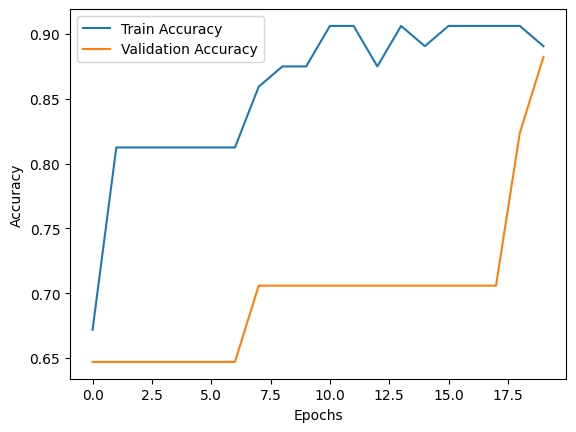

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


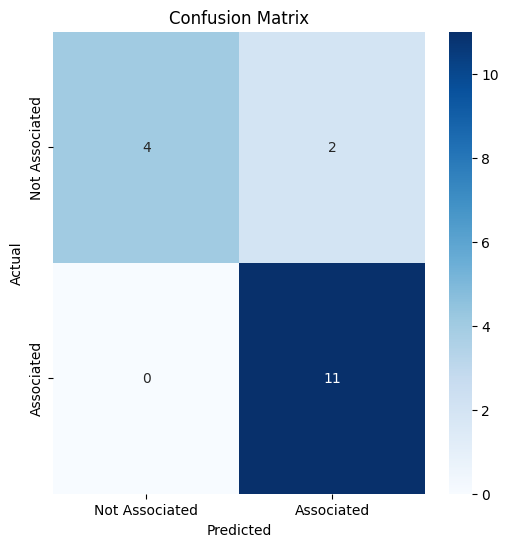

                precision    recall  f1-score   support

Not Associated       1.00      0.67      0.80         6
    Associated       0.85      1.00      0.92        11

      accuracy                           0.88        17
     macro avg       0.92      0.83      0.86        17
  weighted avg       0.90      0.88      0.88        17



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Not Associated", "Associated"]))


In [ ]:
pip install shap


PermutationExplainer explainer: 18it [01:29,  5.24s/it]


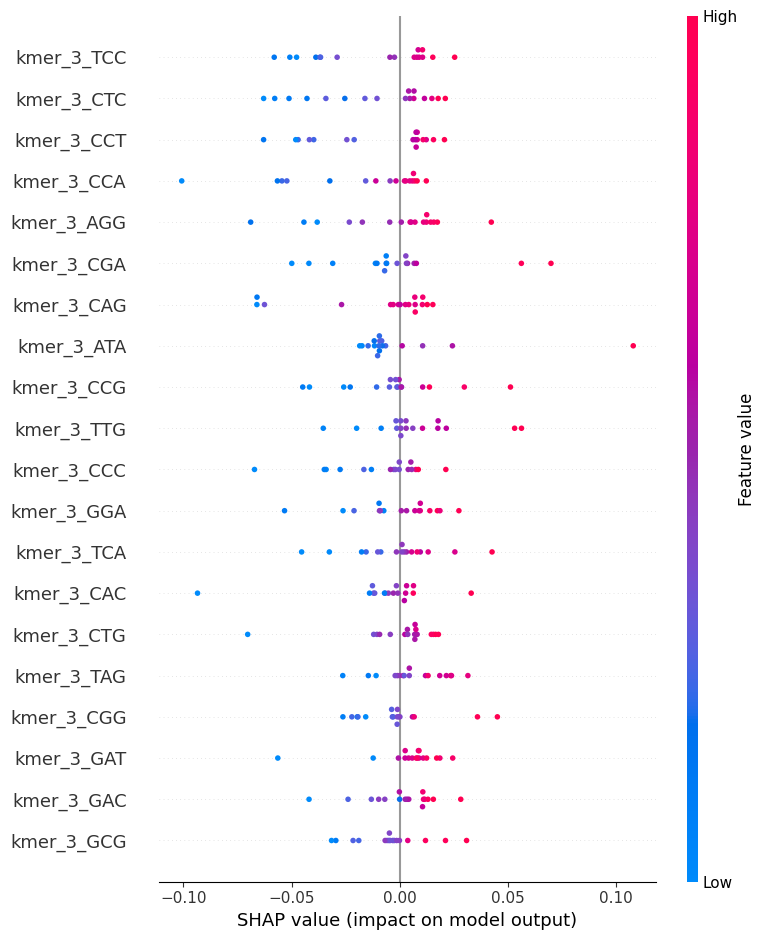

In [ ]:
import shap #to show impactful features we are using

# Create SHAP explainer for your model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Display summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
